# Libs and pre-definitions

In [ ]:
a

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from torch import nn

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data

# Train classifier

## Definitions

In [5]:
CREATE_DIR = True #If true, creates directories to save model (weights_path)
LIVE_PLOT = False #If True, plot* loss while training. If 'print', print loss per epoch
SAVE_CHECKPOINT = True #If True, save (and update) model weights for the best epoch (smallest validation loss)
SAVE_ALL = False #If True, saves weights and trainer at the end of training

N_EPOCHS = 200

In [6]:
#params = {'train_batch_size': 32, 'validation_size': 0.0, 'test_batch_size': 10}

In [7]:
#loss_criterion = sigmoid_loss(data.n_classes)

In [8]:
class new_BCE(nn.BCELoss):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    def forward(self,x,y):
        y = y.unsqueeze(-1).float()
        return super().forward(x,y)
        
loss_criterion = new_BCE()#nn.CrossEntropyLoss()

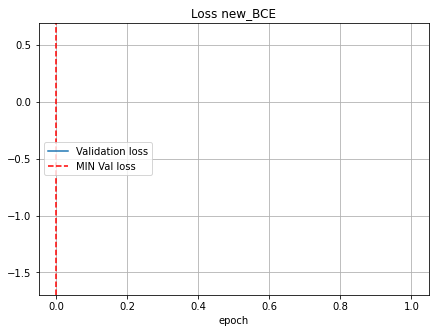

Acc_val (max): 51.93 (51.93) | Progress::   0%|          | 0/200 [02:44<?, ?it/s]

In [ ]:
for MODEL_ARC in ['VGG_16','ResNet50','WideResNet','ResNet18']:
    for DATA in ['Cifar10','Cifar100']:
        DATA = 'ImbalanceBinary'+DATA
        for IMB_RATIO in [1,0.5,0.2,0.1,0.01]:
            data = torch_data.__dict__[DATA](data_dir = DATA_PATH,imbalance_ratio = IMB_RATIO)
            num_classes = 1
            model_class = models.__dict__[MODEL_ARC]

            weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)

            if CREATE_DIR and not os.path.isdir(weights_path):
                os.makedirs(weights_path)
                
            name = MODEL_ARC + '_' + DATA + f'RATIO_{IMB_RATIO}'
            model = model_class(num_classes = num_classes).to(dev)
            model.name = name
            model.classifier = torch.nn.Sequential(model.classifier, torch.nn.Sigmoid())
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum = 0.9,weight_decay = 5e-4,nesterov = True)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)
            model_trainer = TE.Trainer(model,optimizer,loss_criterion, None,data.test_dataloader,lr_scheduler = scheduler)
            model_trainer.fit(data.train_dataloader,N_EPOCHS, live_plot = LIVE_PLOT,save_checkpoint = SAVE_CHECKPOINT,PATH = weights_path)
            print(f'model = {MODEL_ARC}, Data = {DATA}')

            model.eval()
            acc = TE.model_acc(model,data.train_dataloader)
            print('Conjunto de treinamento: acc = ', acc)
            acc = TE.model_acc(model,data.test_dataloader)
            print('Conjunto de teste: acc = ', acc)
            print(f'Conjunto de teste: MAX acc (argmax epoch) = {max(model_trainer.hist_val.acc_list)}({np.argmax(model_trainer.hist_val.acc_list)})')

            if SAVE_ALL:
                model_trainer.save_all(weights_path, PATH_TRAINER,name)